In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.misc as mutil
import utils.network as qnet

reload(polc)
reload(expt)
reload(qnet)
reload(mutil);

## Simulation Parameters

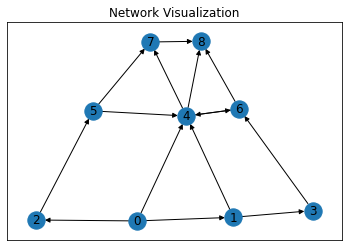

In [2]:
# simulation lengths 
# Use T_horizon = 10000 and N_runs = 500 to recreate the plots from the paper
T_horizon = 100000 # time horizon 
N_runs = 5 # number of simulations

# noise and arrival rates
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
noise_distribution = random_uniform # np.random.standard_normal
noise_variance = 0.05 # sigma^2
arrival_rate   = 4 # lambda

# algorithm parameters
beta  = 4.5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
N_nodes          = 9
source_node      = 0
destination_node = 8
edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, noise_distribution,
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
mutil.visualize_network(edges_list, N_nodes)

## Static Policy

In [3]:
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)
stat_cost_at_tt = (stat_edge_rates@true_edge_costs)*np.ones([T_horizon,])
stat_cost_till_tt = stat_cost_at_tt*np.arange(0,T_horizon)

## DPOP Policy (Unknown T, using doubling trick)

In [4]:
# intialization
T_horizon_next = 1
my_network = qnet.OnlineQueueNetwork(simulation_params, custom_seed = 13)
while(T_horizon_next < T_horizon):
    # T doubling step
    T_horizon_next = min(2*T_horizon_next, T_horizon)

    # change parameters for this value of T
    simulation_params = expt.set_simulation_params(simulation_params, T_horizon_next)
    my_network.T_horizon = T_horizon_next

    # run experiment for this value of T
    my_network = expt.run_experiment(simulation_params, queueing_network = my_network)
    
# save cost and backlog values
unknownT_tran_cost_at_tt, unknownT_backlog_at_tt = expt.calculate_per_time_metrics(my_network)
unknownT_tran_cost_till_tt, unknownT_backlog_cost_at_tt = expt.calculate_total_costs(my_network)
unknownT_regret = unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt - stat_cost_till_tt

## DPOP Policy (Known T, no doubling trick)

In [13]:
# change parameters for this value of T
simulation_params = expt.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
knownT_network = expt.run_experiment(simulation_params, custom_seed = 13)

# save cost and backlog values
knownT_tran_cost_at_tt, knownT_backlog_at_tt = expt.calculate_per_time_metrics(knownT_network)
knownT_tran_cost_till_tt, knownT_backlog_cost_at_tt = expt.calculate_total_costs(knownT_network)
knownT_regret = knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt - stat_cost_till_tt

## Oracle Policy

In [36]:
# change parameters for this value of T and set noise to 0 (oracle)
simulation_params.noise_variance = 0
simulation_params.beta = 0
simulation_params = expt.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
oracle_network = expt.run_experiment(simulation_params, custom_seed = 13)

# save cost and backlog values
oracle_tran_cost_at_tt, oracle_backlog_at_tt = expt.calculate_per_time_metrics(oracle_network)
oracle_tran_cost_till_tt, oracle_backlog_cost_at_tt = expt.calculate_total_costs(oracle_network)
oracle_regret = oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt - stat_cost_till_tt

## Results Comparison

In [37]:
save_result = np.vstack((stat_cost_till_tt, 
                         unknownT_tran_cost_at_tt, unknownT_backlog_at_tt,
                         unknownT_tran_cost_till_tt, unknownT_backlog_cost_at_tt,
                         knownT_tran_cost_at_tt, knownT_backlog_at_tt,
                         knownT_tran_cost_till_tt, knownT_backlog_cost_at_tt,
                         oracle_tran_cost_at_tt, oracle_backlog_at_tt,
                         oracle_tran_cost_till_tt, oracle_backlog_cost_at_tt))
save_file = 'run-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
# np.save('./results/' + save_file, save_result)

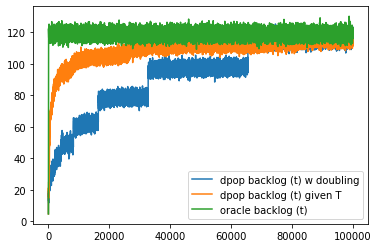

In [38]:
plt.plot(unknownT_backlog_at_tt, label = 'dpop backlog (t) w doubling')
plt.plot(knownT_backlog_at_tt, label = 'dpop backlog (t) given T')
plt.plot(oracle_backlog_at_tt, label = 'oracle backlog (t)')
plt.legend()
plt.show()

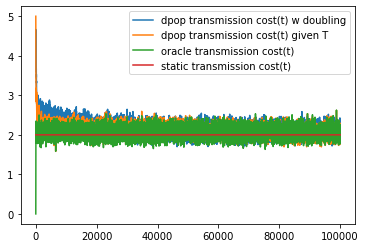

In [39]:
def windowed_average(input_array, window_size = 15):
    output_array = np.convolve(input_array, np.ones(window_size)/window_size, mode='valid')
    return np.append(input_array[0], output_array) # append used to match input and output size

plt.plot(windowed_average(unknownT_tran_cost_at_tt), label = 'dpop transmission cost(t) w doubling')
plt.plot(windowed_average(knownT_tran_cost_at_tt), label = 'dpop transmission cost(t) given T')
plt.plot(windowed_average(oracle_tran_cost_at_tt), label = 'oracle transmission cost(t)')
plt.plot(stat_cost_at_tt, label = 'static transmission cost(t)')
plt.legend()
plt.show()

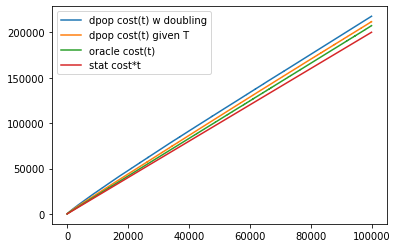

In [40]:
plt.plot(unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt, label = 'dpop cost(t) w doubling')
plt.plot(knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt, label = 'dpop cost(t) given T')
plt.plot(oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt, label = 'oracle cost(t)')
plt.plot(stat_cost_till_tt, label = 'stat cost*t')
plt.legend()
plt.show()

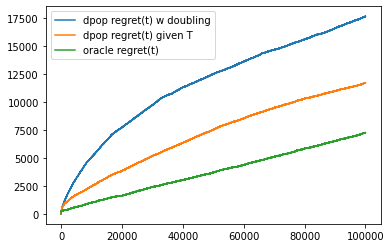

In [41]:
plt.plot(unknownT_regret, label = 'dpop regret(t) w doubling')
plt.plot(knownT_regret, label = 'dpop regret(t) given T')
plt.plot(oracle_regret, label = 'oracle regret(t)')
plt.legend()
plt.show()